# Shan-Chen Two-Component Lattice Boltzmann

In [1]:
from lbmpy.session import *
from lbmpy.updatekernels import create_stream_pull_with_output_kernel
from lbmpy.macroscopic_value_kernels import macroscopic_values_getter, macroscopic_values_setter
from lbmpy.maxwellian_equilibrium import get_weights

This is based on section 9.3.3 of Krüger et al.'s "The Lattice Boltzmann Method", Springer 2017 (http://www.lbmbook.com).
Sample code is available at [https://github.com/lbm-principles-practice/code/](https://github.com/lbm-principles-practice/code/blob/master/chapter9/shanchen.cpp).

## Parameters

In [2]:
N = 64       # domain size
omega_a = 1. # relaxation rate of first component
omega_b = 1. # relaxation rate of second component

# interaction strength
g_aa = 0.
g_ab = g_ba = 6.
g_bb = 0.

rho0 = 1.

stencil = LBStencil(Stencil.D2Q9)
weights = get_weights(stencil, c_s_sq=sp.Rational(1,3))

## Data structures

We allocate two sets of PDF's, one for each phase. Additionally, for each phase there is one field to store its density and velocity.

To run the simulation on GPU, change the `default_target` to gpu

In [3]:
dim = len(stencil[0])
dh = ps.create_data_handling((N, ) * dim, periodicity=True, default_target='cpu')

src_a = dh.add_array('src_a', values_per_cell=len(stencil))
dst_a = dh.add_array_like('dst_a', 'src_a')

src_b = dh.add_array('src_b', values_per_cell=len(stencil))
dst_b = dh.add_array_like('dst_b', 'src_b')

ρ_a = dh.add_array('rho_a')
ρ_b = dh.add_array('rho_b')
u_a = dh.add_array('u_a', values_per_cell=dh.dim)
u_b = dh.add_array('u_b', values_per_cell=dh.dim)

## Force & combined velocity

The two LB methods are coupled using a force term. Its symbolic representation is created in the next cells.
The force value is not written to a field, but directly evaluated inside the collision kernel.

The force between the two components is
$\vec{F}_k(\vec{x})=-\psi(\rho_k(\vec{x}))\sum\limits_{k^\prime\in\{A,B\}}g_{kk^\prime}\sum\limits_{i=1}^{q}w_i\psi(\rho_{k^\prime}(\vec{x}+\vec{c}_i))\vec{c}_i$
for $k\in\{A,B\}$
and with 
$\psi(\rho)=\rho_0\left[1-\exp(-\rho/\rho_0)\right]$.

In [4]:
def psi(dens):
    return rho0 * (1. - sp.exp(-dens / rho0));

In [5]:
zero_vec = sp.Matrix([0] * dh.dim) 

force_a = zero_vec
for factor, ρ in zip([g_aa, g_ab], [ρ_a, ρ_b]):
    force_a += sum((psi(ρ[d]) * w_d * sp.Matrix(d)
                    for d, w_d in zip(stencil, weights)), 
                   zero_vec) * psi(ρ_a.center) * -1 * factor

force_b = zero_vec
for factor, ρ in zip([g_ba, g_bb], [ρ_a, ρ_b]):
    force_b += sum((psi(ρ[d]) * w_d * sp.Matrix(d)
                    for d, w_d in zip(stencil, weights)), 
                   zero_vec) * psi(ρ_b.center) * -1 * factor

The barycentric velocity, which is used in place of the individual components' velocities in the equilibrium distribution and Guo force term, is
$\vec{u}=\frac{1}{\rho_a+\rho_b}\left(\rho_a\vec{u}_a+\frac{1}{2}\vec{F}_a+\rho_b\vec{u}_b+\frac{1}{2}\vec{F}_b\right)$.

In [6]:
u_full = [(ρ_a.center * u_a(i) + force_a[i]/2 + 
           ρ_b.center * u_b(i) + force_b[i]/2) / (ρ_a.center + ρ_b.center)
          for i in range(dh.dim)]

## Kernels

In [7]:
lbm_config_a = LBMConfig(stencil=stencil, relaxation_rate=omega_a, compressible=True,
                         velocity_input=u_full, density_input=ρ_a, force_model=ForceModel.GUO, 
                         force=force_a, kernel_type='collide_only')

lbm_config_b = LBMConfig(stencil=stencil, relaxation_rate=omega_b, compressible=True,
                         velocity_input=u_full, density_input=ρ_b, force_model=ForceModel.GUO, 
                         force=force_b, kernel_type='collide_only')



collision_a = create_lb_update_rule(lbm_config=lbm_config_a,
                                    optimization={'symbolic_field': src_a})

collision_b = create_lb_update_rule(lbm_config=lbm_config_b,
                                    optimization={'symbolic_field': src_b})

In [8]:
stream_a = create_stream_pull_with_output_kernel(collision_a.method, src_a, dst_a, 
                                                 {'density': ρ_a, 'velocity': u_a})
stream_b = create_stream_pull_with_output_kernel(collision_b.method, src_b, dst_b, 
                                                 {'density': ρ_b, 'velocity': u_b})

opts = {'cpu_openmp': 1,  # number of threads when running on CPU
        'target': dh.default_target}
stream_a_kernel = ps.create_kernel(stream_a, **opts).compile()
stream_b_kernel = ps.create_kernel(stream_b, **opts).compile()
collision_a_kernel = ps.create_kernel(collision_a, **opts).compile()
collision_b_kernel = ps.create_kernel(collision_b, **opts).compile()

## Initialization

In [9]:
init_a = macroscopic_values_setter(collision_a.method, velocity=(0, 0), 
                                   pdfs=src_a.center_vector, density=ρ_a.center)
init_b = macroscopic_values_setter(collision_b.method, velocity=(0, 0), 
                                   pdfs=src_b.center_vector, density=ρ_b.center)
init_a_kernel = ps.create_kernel(init_a, ghost_layers=0).compile()
init_b_kernel = ps.create_kernel(init_b, ghost_layers=0).compile()

In [10]:
def init():
    dh.fill(ρ_a.name, 0.1, slice_obj=ps.make_slice[:, :0.5])
    dh.fill(ρ_a.name, 0.9, slice_obj=ps.make_slice[:, 0.5:])

    dh.fill(ρ_b.name, 0.9, slice_obj=ps.make_slice[:, :0.5])
    dh.fill(ρ_b.name, 0.1, slice_obj=ps.make_slice[:, 0.5:])

    dh.run_kernel(init_a_kernel)
    dh.run_kernel(init_b_kernel)
    
    dh.fill(u_a.name, 0.0)
    dh.fill(u_b.name, 0.0)

## Timeloop

In [11]:
sync_pdfs = dh.synchronization_function([src_a.name, src_b.name])
sync_ρs = dh.synchronization_function([ρ_a.name, ρ_b.name])

def time_loop(steps):
    dh.all_to_gpu()
    for i in range(steps):
        sync_ρs()  # collision kernel evaluates force values, that depend on neighboring ρ's
        dh.run_kernel(collision_a_kernel)
        dh.run_kernel(collision_b_kernel)
        
        sync_pdfs()
        dh.run_kernel(stream_a_kernel)
        dh.run_kernel(stream_b_kernel)
        
        dh.swap(src_a.name, dst_a.name)
        dh.swap(src_b.name, dst_b.name)
    dh.all_to_cpu()

In [12]:
def plot_ρs():
    plt.figure(dpi=200)
    plt.subplot(1,2,1)
    plt.title("$\\rho_A$")
    plt.scalar_field(dh.gather_array(ρ_a.name), vmin=0, vmax=2)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.title("$\\rho_B$")
    plt.scalar_field(dh.gather_array(ρ_b.name), vmin=0, vmax=2)
    plt.colorbar()

## Run the simulation
### Initial state

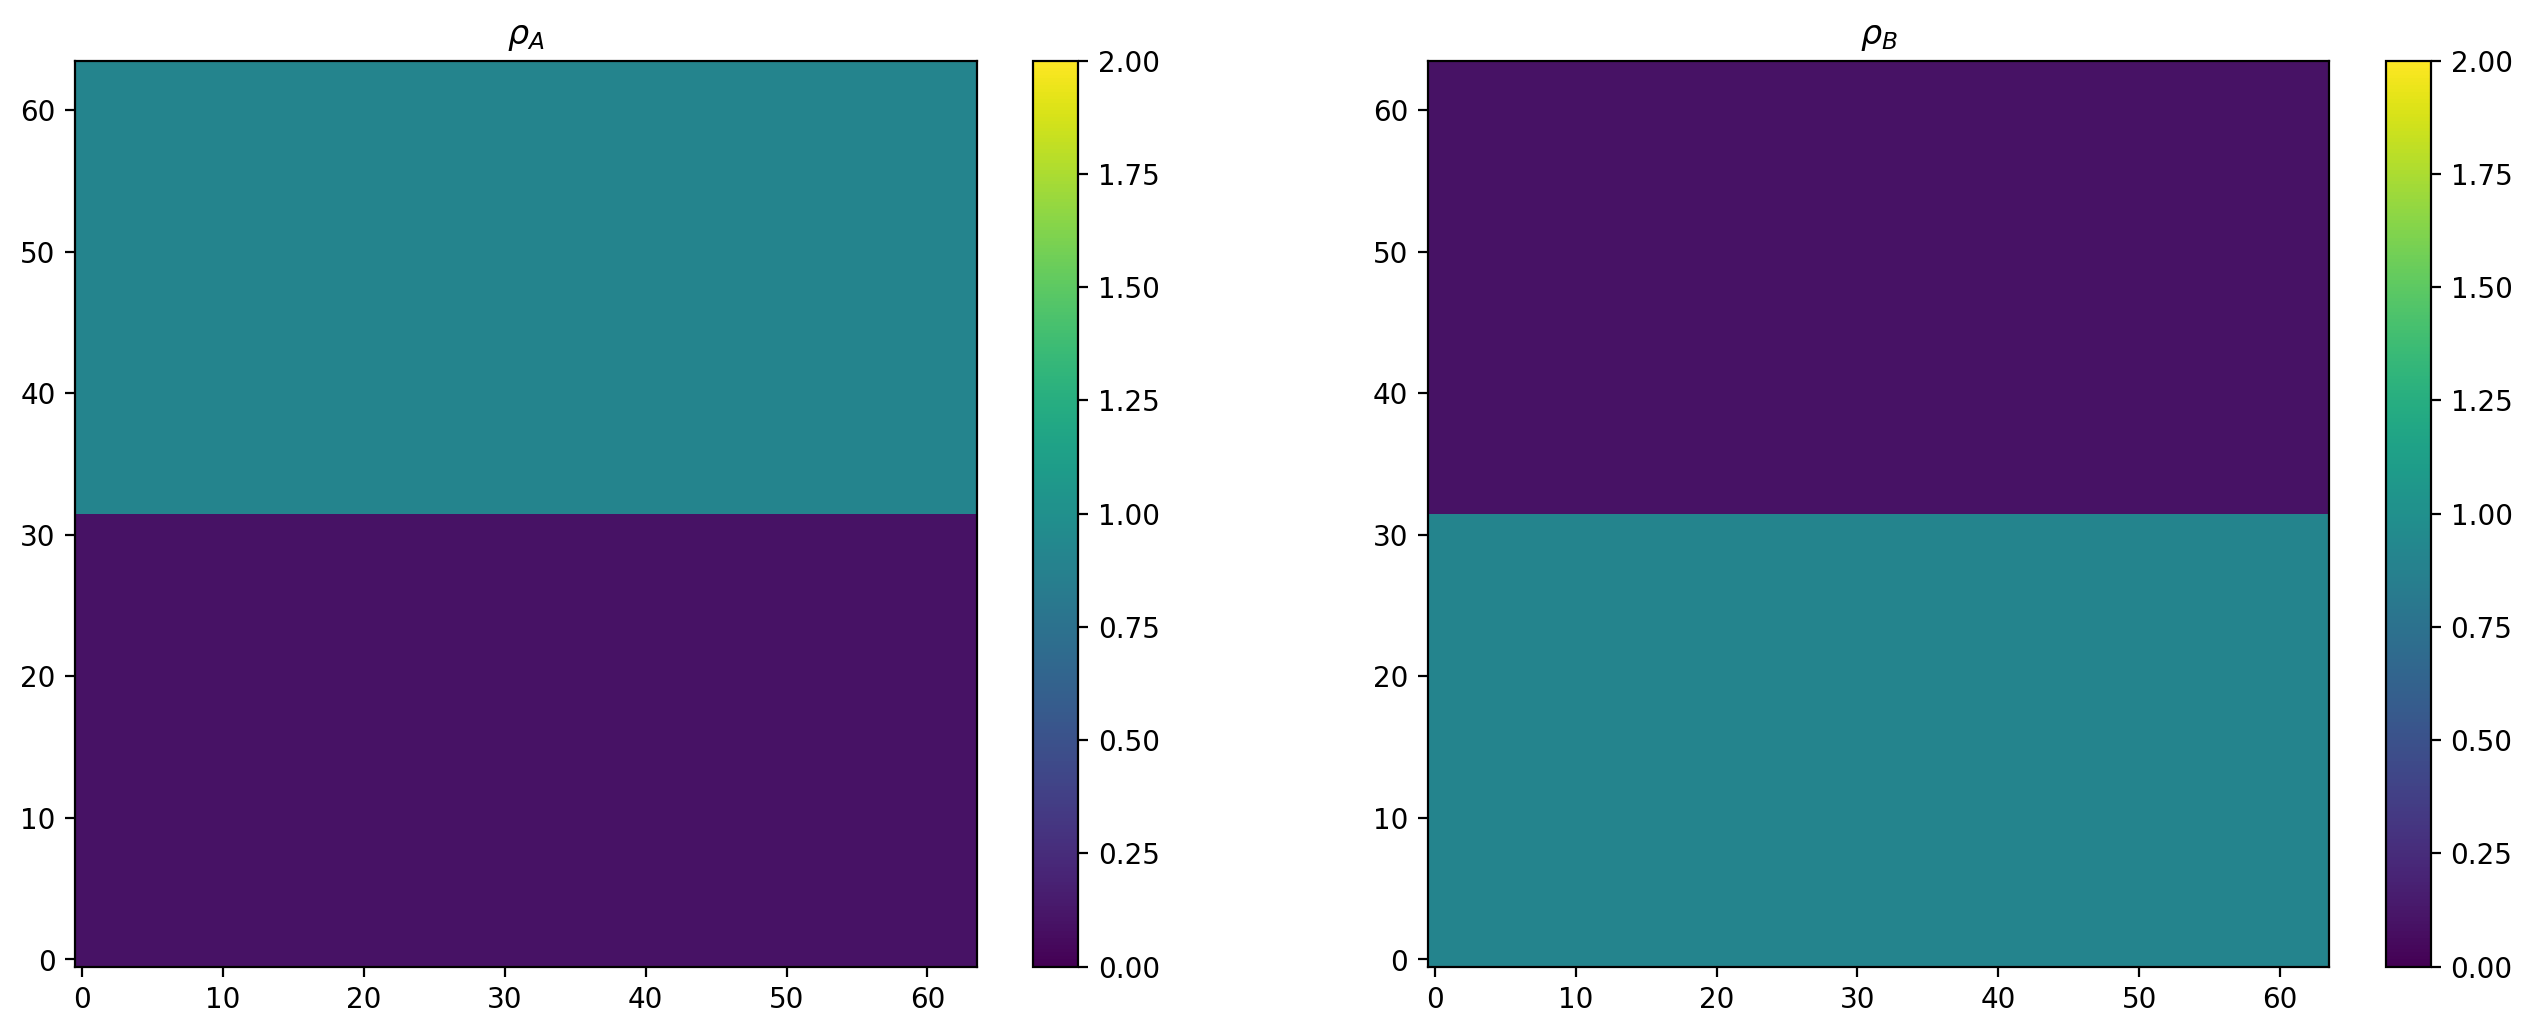

In [13]:
init()
plot_ρs()

### Check the first time step against reference data

The reference data was obtained with the [sample code](https://github.com/lbm-principles-practice/code/blob/master/chapter9/shanchen.cpp) after making the following changes:
```c++
const int nsteps = 1000;
const int noutput = 1;
const int nfluids = 2;
const double gA = 0;
```

Remove the next cell if you changed the parameters at the beginning of this notebook.

In [14]:
init()
time_loop(1)
ref_a = np.array([0.133183, 0.0921801, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0921801, 0.133183, 0.719568, 1.05507, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.05507, 0.719568])
ref_b = np.array([0.719568, 1.05507, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.05507, 0.719568, 0.133183, 0.0921801, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0921801, 0.133183])
assert np.allclose(dh.gather_array(ρ_a.name)[0], ref_a)
assert np.allclose(dh.gather_array(ρ_b.name)[0], ref_b)

### Run the simulation until converged

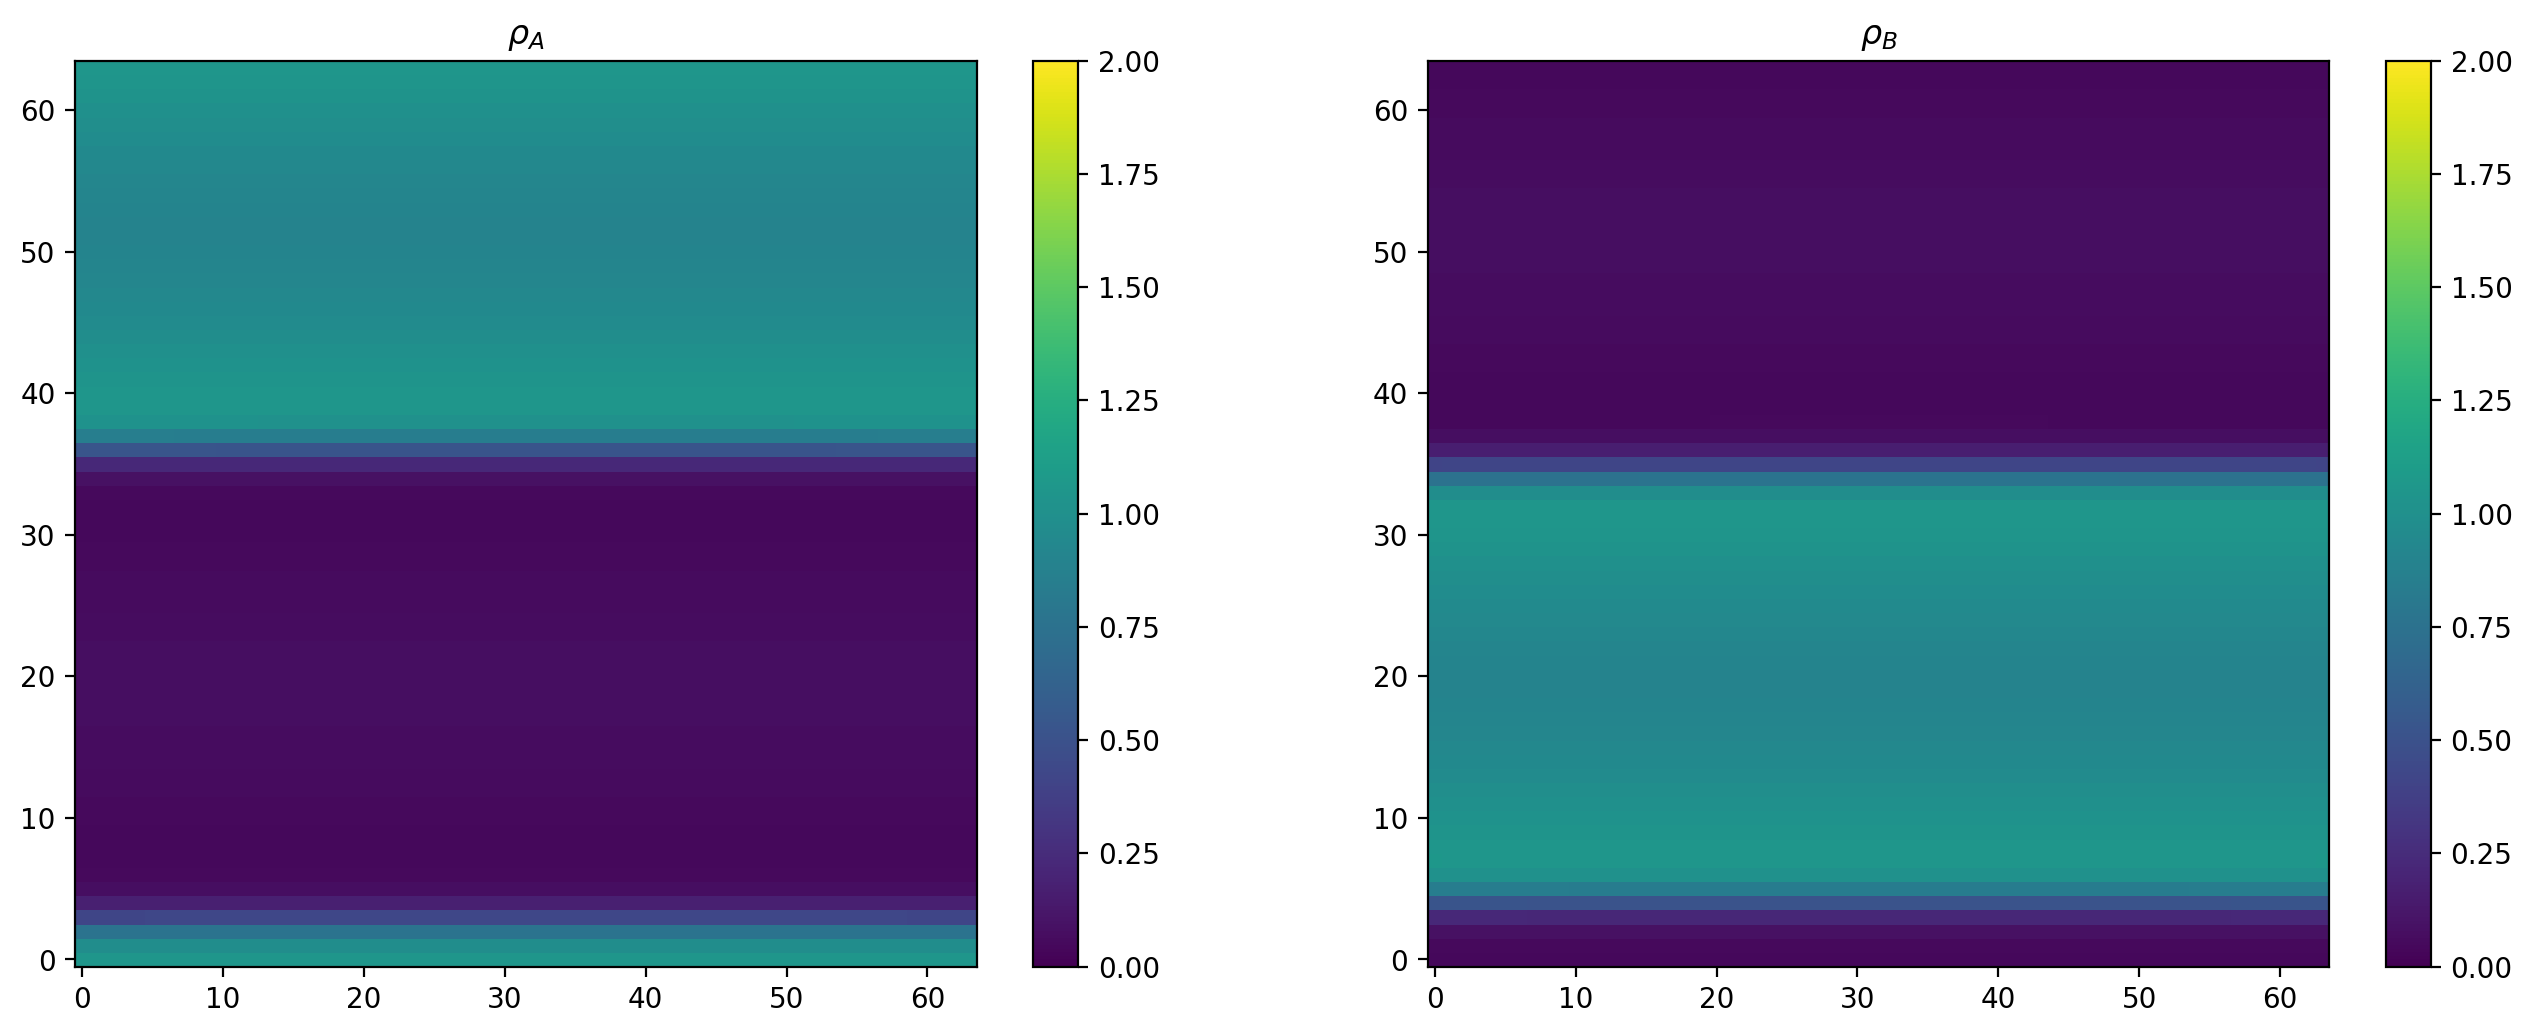

In [15]:
init()
time_loop(1000)
plot_ρs()